## Necessary Libraries

In [1]:
## pyb stuff
import pybaseball as pyb
from pybaseball import  playerid_lookup
from pybaseball import statcast_pitcher
from pybaseball import pitching_stats
from pybaseball import batting_stats
from pybaseball import schedule_and_record

import pandas as pd 
pd.set_option('display.max_columns', None)

import numpy as np

## added yesterday's date so the data we get is updated everytime the statcast data cell is ran
from datetime import date, timedelta, datetime
today = date.today()
yesterday = today - timedelta(days=1)
formatted_date = yesterday.strftime("%Y-%m-%d")

import warnings
warnings.filterwarnings("ignore")

## Defining Functions

In [2]:
start_date = '2024-03-01'
end_date = '2025-08-15'

statcast_data = pyb.statcast(start_date, end_date)

statcast_data = statcast_data.sort_values(by='game_date').reset_index(drop=True)
statcast_data = statcast_data[~statcast_data['pitch_type'].isna()].sort_values(by='game_date').reset_index(drop=True) ## gets rid of the null pitches
statcast_data.head()

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 400/400 [01:41<00:00,  3.92it/s]


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,fielder_2,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,hyper_speed,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
0,FF,2024-03-15,93.8,-1.45,6.17,"Houser, Adrian",608336,605288,NaN,foul,<NA>,<NA>,<NA>,<NA>,11,Joey Gallo pops out to catcher Francisco Alvar...,S,L,R,NYM,WSH,S,<NA>,NaN,0,0,2024,-0.76,1.26,-0.88,2.99,<NA>,<NA>,<NA>,2,1,Top,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3.157271,-136.531806,-5.310178,-10.239995,29.364474,-15.430712,3.43,1.73,258,80.4,54,94.3,2275,6.5,747961,682626,668901,621563,683146,596019,621466,664056,516782,53.99,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,4,1,4-Seam Fastball,0,1,1,0,1,0,1,0,Infield shade,Standard,222,0.0,-0.041,<NA>,<NA>,<NA>,0.041,88.0,-1,1,0.433,0.567,31,30,31,31,1,0,<NA>,<NA>,<NA>,<NA>,1.32,0.76,-0.76,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,FF,2024-03-15,94.4,-2.21,6.03,"Smith-Shawver, AJ",608348,700363,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,8,Carson Kelly flies out to right fielder Eli Wh...,S,R,R,DET,ATL,X,9,fly_ball,1,0,2024,-0.85,1.65,-0.17,1.68,<NA>,682985,<NA>,1,3,Bot,193.19,114.21,<NA>,<NA>,<NA>,<NA>,7.28227,-137.035703,-9.388771,-12.290337,30.408892,-9.464813,3.28,1.61,268,91.1,47,95.3,2118,6.9,747956,644433,621566,645277,641645,606115,672284,671739,642201,53.56,0.003,<NA>,0.0,<NA>,0,0,3,24,2,4-Seam Fastball,4,0,4,0,0,4,4,0,Standard,Standard,212,-0.011,-0.289,<NA>,<NA>,0.006,0.289,91.1,4,4,0.909,0.909,21,29,22,30,2,1,<NA>,<NA>,<NA>,<NA>,0.92,0.85,0.85,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,SL,2024-03-15,86.5,-2.46,6.08,"Smith-Shawver, AJ",570482,700363,NaN,swinging_strike,<NA>,<NA>,<NA>,<NA>,5,Gio Urshela singles on a line drive to center ...,S,R,R,DET,ATL,S,<NA>,NaN,1,0,2024,0.21,0.54,-0.23,2.86,678009,<NA>,<NA>,0,3,Bot,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,4.94394,-126.116968,-2.745282,1.454022,19.936556,-26.01901,3.46,1.68,<NA>,<NA>,<NA>,88.2,2120,6.7,747956,644433,621566,645277,641645,606115,672284,671739,642201,53.78,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,21,2,Slider,2,0,2,0,0,2,2,0,Strategic,Standard,220,0.0,-0.093,<NA>,<NA>,<NA>,0.093,<NA>,2,2,0.836,0.836,21,32,22,33,2,1,<NA>,<NA>,<NA>,<NA>,2.44,-0.21,-0.21,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,CU,2024-03-15,74.1,-2.17,6.06,"Smith-Shawver, AJ",570482,700363,NaN,ball,<NA>,<NA>,<NA>,<NA>,11,Gio Urshela singles on a line drive to center ...,S,R,R,DET,ATL,B,<NA>,NaN,1,1,2024,1.02,-1.06,-0.91,3.55,678009,<NA>,<NA>,0,3,Bot,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.800755,-107.839599,4.028733,7.814088,18.8554,-41.388552,3.46,1.68,<NA>,<NA>,<NA>,74.8,2246,6.8,747956,644433,621566,645277,641645,606115,672284,671739,642201,53.65,<NA>,<NA>,<NA>,<NA>,<N

In [3]:
mlb_pitchers = statcast_data.groupby(['pitcher', 'pitch_name']).agg(pitcher_name = ('player_name', 'max'),
                                                                     handedness = ('p_throws', 'max'),
                                                                     count_pitch = ('player_name', 'count'),
                                                                     spin_rate = ('release_spin_rate', 'mean'),
                                                                     release_speed = ('release_speed', 'mean'), 
                                                                     horz_break = ('pfx_x', 'mean'), 
                                                                     vert_break = ('pfx_z', 'mean'), 
                                                                     extension = ('release_extension', 'mean'), 
                                                                     spin_axis = ('spin_axis', 'mean')
                                                                     ).reset_index()

In [4]:
mlb_pitchers.head()

,pitcher,pitch_name,pitcher_name,handedness,count_pitch,spin_rate,release_speed,horz_break,vert_break,extension,spin_axis
0,434378,4-Seam Fastball,"Verlander, Justin",R,1610,2414.603106,93.849752,-0.732888,1.573752,6.017888,206.999379
1,434378,Changeup,"Verlander, Justin",R,314,1751.605096,84.502229,-1.113567,0.782675,6.043949,229.531847
2,434378,Curveball,"Verlander, Justin",R,609,2710.807882,78.127586,0.613383,-1.067028,6.000657,38.284072
3,434378,Sinker,"Verlander, Justin",R,10,2449.3,92.88,-1.004,1.345,5.99,198.7
4,434378,Slider,"Verlander, Justin",R,734,2468.516349,87.233379,0.324755,0.494223,6.047684,171.158038


In [5]:
total_pitches = mlb_pitchers.groupby(['pitcher_name'])[['count_pitch']].sum().reset_index()
total_pitches = total_pitches.rename(columns = {'count_pitch': 'total_pitches'})
mlb_pitchers_master = mlb_pitchers.merge(total_pitches, on = ['pitcher_name'], how = 'left')
mlb_pitchers_master['usage%'] = round((mlb_pitchers_master['count_pitch'] / mlb_pitchers_master['total_pitches']) * 100, 1)
mlb_pitchers_master

,pitcher,pitch_name,pitcher_name,handedness,count_pitch,spin_rate,release_speed,horz_break,vert_break,extension,spin_axis,total_pitches,usage%
0,434378,4-Seam Fastball,"Verlander, Justin",R,1610,2414.603106,93.849752,-0.732888,1.573752,6.017888,206.999379,3389,47.5
1,434378,Changeup,"Verlander, Justin",R,314,1751.605096,84.502229,-1.113567,0.782675,6.043949,229.531847,3389,9.3
2,434378,Curveball,"Verlander, Justin",R,609,2710.807882,78.127586,0.613383,-1.067028,6.000657,38.284072,3389,18.0
3,434378,Sinker,"Verlander, Justin",R,10,2449.3,92.88,-1.004,1.345,5.99,198.7,3389,0.3
4,434378,Slider,"Verlander, Justin",R,734,2468.516349,87.233379,0.324755,0.494223,6.047684,171.158038,3389,21.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6150,829272,Changeup,"Ogasawara, Shinnosuke",L,52,1612.519231,79.948077,1.227308,0.650962,6.167308,126.846154,255,20.4
6151,829272,Knuckle Curve,"Ogasawara, Shinnosuke",L,40,2718.325,71.5475,-0.61275,-1.6745,6.0075,342.375,255,15.7
6152,829272,Sinker,"Ogasawara, Shinnosuke",L,2,2168.5,88.55,1.255,0.995,6.25,137.5,255,0.8
6153,829272,Slider,"Ogasawara, Shinnosuke",L,54,2431.740741,80.972222,-0.210185,0.182222,6.175926,225.759259,255,21.2


In [6]:
trackman = pd.read_csv('../../Files/merged_trackman_games.csv')

In [16]:
def clean_pitch_names(row):
    
    if row['TaggedPitchType'] == 'Splitter':
        row['TaggedPitchType'] = 'Split-Finger'
    if row['TaggedPitchType'] == 'FourSeamFastBall':
        row['TaggedPitchType'] = 'Fastball'
    if row['TaggedPitchType'] == 'ChangeUp':
        row["TaggedPitchType"] = 'Changeup'
    if row['TaggedPitchType'] == 'Fastball':
        row['TaggedPitchType'] = '4-Seam Fastball'
    
    row['HorzBreak'] = row['HorzBreak'] * (-1)
        
    return row

trackman = trackman.apply(clean_pitch_names, axis = 1)
trackman

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,HomeTeamForeignID,AwayTeamForeignID,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence
0,1,2025-03-25,18:08:29.92,1,1,"Martin, Landon",1.000365e+09,Right,CAL_FUL,"Watson, Rex",1.000336e+09,Left,SAN_TOR,Undefined,1,Top,0,0,0,4-Seam Fastball,Four-Seam,InPlay,Undefined,Popup,Out,1,0,88.86171,-1.466742,-1.379080,1973.862694,199.693179,12:45,5.82053,0.88575,5.86519,-20.13757,15.62883,-5.14768,2.77915,0.03336,80.48807,-5.279977,-0.455642,0.430436,82.05061,73.608538,-26.909913,NaN,NaN,NaN,NaN,NaN,34.69425,NaN,NaN,-3.07658,8.82300,-0.77708,50.0,5.69011,2.88805,-128.91094,-3.92086,-5.11995,29.55922,-17.49106,CAL_FUL,SAN_TOR,GoodwinField,D1,BW,20250325-GoodwinField-1,d4cb7a60-09de-11f0-91ec-41cc551cf82d,87.56798,110.06968,NaN,8.37364,NaN,NaN,NaN,0.66494,3.16207,-0.64947,4f69f254-7555-401e-b034-118e07d33b1e,2025-03-26,01:08:29.92,2025-03-25T18:08:29.9246592-07:00,2025-03-26T01:08:29.9246592Z,NaN,v3,471254.0,5320.0,25 March 2025 21:00-sandiego@calstfull,"Ortega, Max",703672,Right,CAL_FUL,dc341f6c-8981-4044-addd-07f5b0d70724,54.63359,-129.96908,14.77961,5.81926,-3.29473,-8.74553,-0.88374,3.07133,-2.55997,NaN,0.66497,30.27848,-13.0026,3.70082,-0.22191,-0.45891,0.20178,0.03247,-0.02858,3.16206,115.45012,-29.52616,3.8369,-0.86047,0.29714,-0.13366,0.0413,-0.00549,-0.64945,-15.37252,-3.67539,1.43911,0.00628,-0.32618,0.15003,0.00737,-0.01489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,Medium,Undefined,NaN,NaN,NaN
1,2,2025-03-25,18:09:07.68,2,1,"Martin, Landon",1.000365e+09,Right,CAL_FUL,"Libed, Nico",8.222970e+05,Right,SAN_TOR,Undefined,1,Top,1,0,0,4-Seam Fastball,Four-Seam,StrikeCalled,Undefined,Undefined,Undefined,0,0,88.80676,-2.887698,-1.987311,2086.802197,201.088936,12:45,5.80890,0.92208,5.79721,-19.77792,16.16832,-5.75107,1.47086,-0.44790,80.64136,-6.616077,-0.957190,0.431517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [17]:
def pitcher_lookup_stats(player_name: str, player_id: int) -> pd.DataFrame:
    """
    Finds all of the pitches for some player from the past 2 seasons
    
    Arguments: player_name: the name of a pitcher (format: Last Name, First Name), player_id: placeholder (unless there's a pitcher with the same name with different ids)
    """
    df = statcast_data[statcast_data['player_name'] == player_name].sort_values(by='game_date').reset_index(drop=True).copy()

    if len(df['pitcher'].unique()) > 1:
        print("There's a pitcher with the same name --> Find out their ID")
        return np.nan
    else:
        pitcher_stats = statcast_data[statcast_data['pitcher'] == df['pitcher'].unique()[0]]

    return pitcher_stats

In [62]:
import matplotlib.pyplot as plt

ucsd_pitcher = 'Weber, Chapman'
mlb_pitcher = 'Estrada, Jeremiah'

def find_pitch_usage_compare(ucsd_pitcher, mlb_pitcher, count = 'All'):
    '''
    Compares the pitch usage of a UCSD pitcher and an MLB pitcher for a given count.
    '''
    
    #Get mlb pitcher pitch stats
    get_count = pitcher_lookup_stats(mlb_pitcher, 0)
    
    #Format current count in a new column
    get_count['current_count'] = list(get_count['balls'].astype(str) + '-' + get_count['strikes'].astype(str))
    
    mlb_count = get_count.groupby(['current_count', 'pitch_name']).agg(
        num_pitches = ('player_name', 'count')
    ).reset_index()
    
    mlb_temp = mlb_count.groupby('current_count').agg(
        total_count_pitches = ('num_pitches', 'sum')).reset_index()
    
    mlb_count_grouped = mlb_count.merge(mlb_temp, on = ['current_count'], how = 'left')
    mlb_count_grouped['usage%_in_count'] = round(mlb_count_grouped['num_pitches'] / mlb_count_grouped['total_count_pitches'] * 100, 1)

    mlb_all = mlb_count.groupby('pitch_name').agg(num_pitches=('num_pitches', 'sum')).reset_index()
    total_count = mlb_all['num_pitches'].sum()
    mlb_all['usage%_in_count'] = round(mlb_all['num_pitches'] / total_count * 100, 1)
    mlb_all['current_count'] = 'all'
    mlb_count_final = pd.concat([mlb_count_grouped, mlb_all[['current_count', 'pitch_name', 'num_pitches', 'usage%_in_count']]], ignore_index=True)
    
    #Get ucsd pitcher pitch stats
    get_count_ucsd = trackman[trackman['Pitcher'] == ucsd_pitcher].copy()
    
    get_count_ucsd['current_count'] = list(get_count_ucsd['Balls'].astype(str) + '-' + get_count_ucsd['Strikes'].astype(str)) 
    
    ucsd_count = get_count_ucsd.groupby(['current_count', 'TaggedPitchType']).agg(
        num_pitches = ('Pitcher', 'count')
    ).reset_index()
    
    ucsd_temp = ucsd_count.groupby('current_count').agg(
        total_count_pitches = ('num_pitches', 'sum')).reset_index()
    
    ucsd_count_grouped = ucsd_count.merge(ucsd_temp, on = ['current_count'], how = 'left')
    ucsd_count_grouped['usage%_in_count'] = round(ucsd_count_grouped['num_pitches'] / ucsd_count_grouped['total_count_pitches'] * 100, 1)
    ucsd_count_filtered = ucsd_count_grouped[ucsd_count_grouped['current_count'] == count].copy()
    
    ucsd_all = ucsd_count.groupby('TaggedPitchType').agg(num_pitches=('num_pitches', 'sum')).reset_index()
    total_all_ucsd = ucsd_all['num_pitches'].sum()
    ucsd_all['usage%_in_count'] = round(ucsd_all['num_pitches'] / total_all_ucsd * 100, 1)
    ucsd_all['current_count'] = 'all'
    ucsd_count_final = pd.concat([ucsd_count_grouped, ucsd_all[['current_count', 'TaggedPitchType', 'num_pitches', 'usage%_in_count']]], ignore_index=True)

    
    ucsd_pivot_count = ucsd_count_final.pivot(index='current_count', columns='TaggedPitchType', values='usage%_in_count').fillna(0)
    mlb_pivot_count = mlb_count_final.pivot(index='current_count', columns='pitch_name', values='usage%_in_count').fillna(0)
    
    return ucsd_pivot_count, mlb_pivot_count
    

weber, estrada = find_pitch_usage_compare('Weber, Chapman', 'Estrada, Jeremiah', count = 'all')

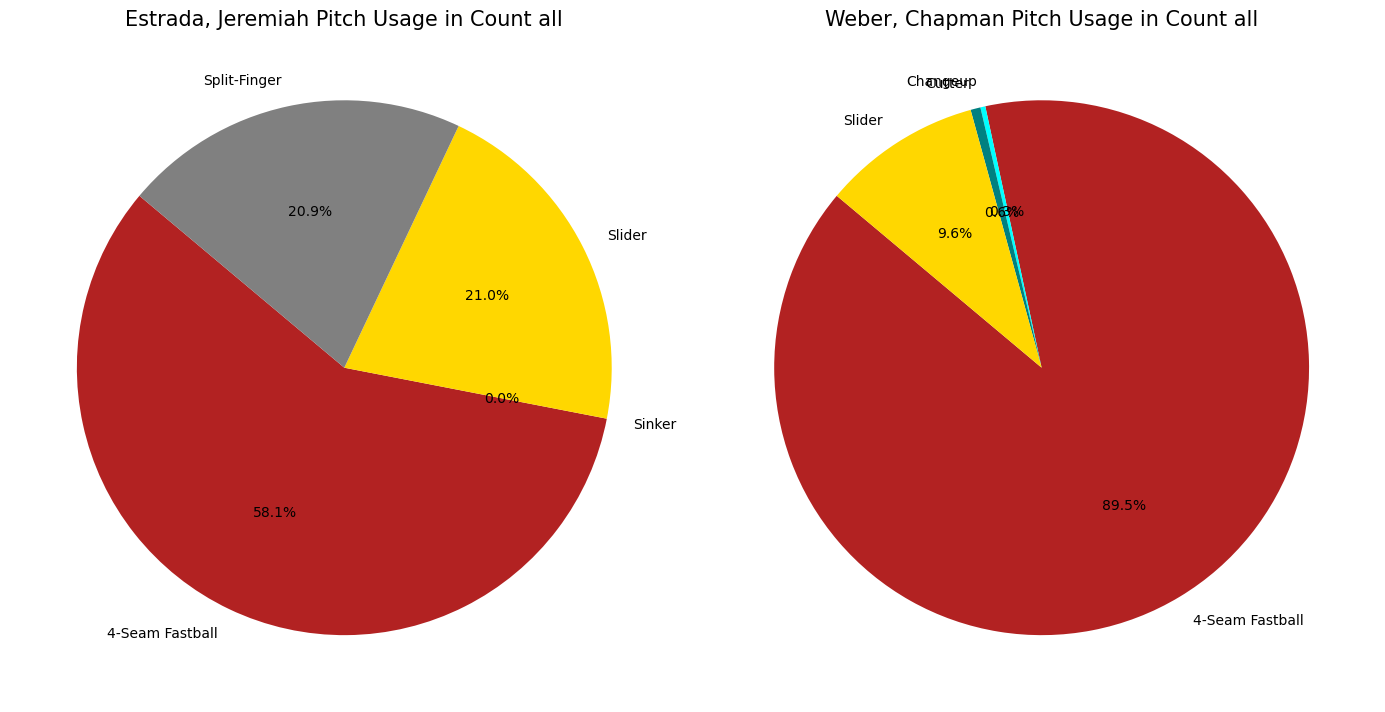

In [65]:
def plot_pitch_compare(ucsd_pitch, mlb_pitch, ucsd_pitcher, mlb_pitcher, count = '0-0'):
    
    ucsd_pitch_new, mlb_pitch_new = ucsd_pitch.reset_index(), mlb_pitch.reset_index()
    
    ucsd_pitch_new = ucsd_pitch_new[ucsd_pitch_new['current_count'] == count]
    mlb_pitch_new = mlb_pitch_new[mlb_pitch_new['current_count'] == count]

    mlb_pitches = list(mlb_pitch.columns)
    ucsd_pitches = list(ucsd_pitch.columns)

    all_pitches = mlb_pitches + ucsd_pitches
    
    # --- Create a consistent color map ---
    color_pitch_map = {
        '4-Seam Fastball': 'firebrick',
        'Sinker': 'darkorange',
        'Cutter': 'teal',
        'Changeup': 'cyan',
        'Slider': 'gold',
        'Curveball': 'forestgreen',
        'Sweeper': 'indigo',
        'Split Finger': 'orchid',
        'TwoSeamFastball': 'gray',
        'Slow Curve': 'gray',
        'Knuckleball': 'gray',
        'Other': 'gray'
    }
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 7))
    
    mlb_pitch_long = mlb_pitch_new.reset_index().melt(
        id_vars="current_count", var_name='pitch_name', value_name='usage%_in_count').sort_values(["current_count", 'pitch_name']).reset_index(drop=True)
    
    mlb_pitch_long = mlb_pitch_long[mlb_pitch_long['pitch_name'] != 'index']
    
    ucsd_pitch_long = ucsd_pitch_new.reset_index().melt(
        id_vars = 'current_count',
        var_name = 'TaggedPitchType',
        value_name = 'usage%_in_count'
    ).sort_values(['current_count', 'TaggedPitchType']).reset_index(drop=True)
    
    ucsd_pitch_long = ucsd_pitch_long[ucsd_pitch_long['TaggedPitchType'] != 'index']

    # MLB pie
    axs[0].pie(
        mlb_pitch_long['usage%_in_count'],
        labels=mlb_pitch_long['pitch_name'],
        autopct='%1.1f%%',
        startangle=140,
        colors= [color_pitch_map.get(pt, 'gray') for pt in mlb_pitch_long['pitch_name']]
    )
    axs[0].set_title(f"{mlb_pitcher} Pitch Usage in Count {count}", fontsize = 15)

    # UCSD pie
    axs[1].pie(
        ucsd_pitch_long['usage%_in_count'],
        labels=ucsd_pitch_long['TaggedPitchType'],
        autopct='%1.1f%%',
        startangle=140,
        colors= [color_pitch_map.get(pt, 'gray') for pt in ucsd_pitch_long['TaggedPitchType']]
    )
    axs[1].set_title(f"{ucsd_pitcher} Pitch Usage in Count {count}", fontsize = 15)

    plt.tight_layout()
    plt.show()
    
plot_pitch_compare(weber, estrada, ucsd_pitcher, mlb_pitcher, count = 'all')

In [71]:
ucsd = trackman[trackman['PitcherTeam'] == 'CSD_TRI']
swung = ucsd[(ucsd['PitchCall'] == 'StrikeSwinging')| (ucsd['PitchCall'] == 'FoulBallNotFieldable')]

#Add average whiff rates for diff pitches

#Calculate whiff%, chase%, CSW%, other batter performance metrics

#Create function for this

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,HomeTeamForeignID,AwayTeamForeignID,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence
252,5,2/22/25,06:36.9,1,5,"Seid, Spencer",809262.0,Left,CSD_TRI,"Dumesnil, Nick",8.250940e+05,Right,CAL_LAN,Undefined,1,Top,0,2,2,Cutter,Cutter,FoulBallNotFieldable,Undefined,Undefined,Undefined,0,0,82.75391,0.359782,1.489249,2093.901788,175.899755,11:45,4.71784,-2.29132,5.26789,-30.82809,10.54906,0.67150,2.48692,-0.94801,76.37353,-5.296197,1.370169,0.462969,70.21627,25.649350,154.118858,3143.596348,NaN,NaN,NaN,NaN,47.2289,NaN,NaN,0.71059,5.54776,2.15565,50.0,4.72807,-3.09744,-120.20904,-0.31317,1.04991,21.17586,-23.97726,CSD_TRI,CAL_LAN,UCSanDiego,D1,BW,20250222-UCSanDiego-1,d03e9d40-f18a-11ef-9456-e7fd19fa9ca5,81.41465,19.98304,NaN,6.38038,NaN,NaN,NaN,0.89093,2.46734,0.87517,f92401d5-ad19-4ab4-801b-f579f4bca033,2/23/25,06:36.9,2025-02-22T18:06:36.8868352-08:00,2025-02-23T02:06:36.8868352Z,NaN,v3,NaN,471762.0,NaN,"Gonzalez, Emiliano",1000081438,Right,CSD_TRI,d50a1850-887b-453d-a2a5-16ceedc05ca3,55.23159,-121.12713,10.58793,4.71911,0.72636,-11.98863,2.29093,-3.14296,0.52495,NaN,0.89093,-83.52440,6.66399,-0.16915,-0.00861,-0.04182,0.14114,-0.14927,0.06323,2.46734,44.57777,-23.99934,2.56795,-0.51091,0.02465,0.13758,-0.15475,0.06623,0.87517,40.52331,-9.33031,1.85443,-0.37750,-0.05384,0.23259,-0.24763,0.10514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,High,Undefined,NaN,NaN,NaN
255,8,2/22/25,07:43.4,2,2,"Seid, Spencer",809262.0,Left,CSD_TRI,"Walters, Andrew",1.000213e+09,Right,CAL_LAN,Undefined,1,Top,1,1,0,4-Seam Fastball,Four-Seam,StrikeSwinging,Undefined,Undefined,Undefined,0,0,90.05831,-1.172813,3.080994,2046.864052,153.426217,11:00,4.74564,-2.28245,5.37098,-15.32434,20.41914,9.55355,2.36727,-0.18714,80.92247,-4.116914,1.386605,0.430299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.78146,10.99229,2.01306,5